# Esame Tecniche di Rappresentazione e Modellizzzazione Dati
## Analisi di un Catalogo di Ammassi di Galassie - Giacomo Tonet

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import emcee
import pygtc
from scipy.optimize import minimize
from colossus.cosmology import cosmology
from colossus.lss import mass_function

## Parte 1 - Visualizzazione e Analisi dei Dati

Si usa Pandas per riorganizzare i dati della tabella 'Euclid_ammassi.csv' in funzione del Redshift; ne si studiano alcune proprietà statistiche e si rappresenta graficamente la distrubizione delle masse.

In [24]:
#Lettura dati: si elimina la colonna senza dati
df = pd.read_csv('Euclid_ammassi.csv').drop('Unnamed: 0', axis=1)                        


#DataFrame con i dati dell'analisi statistica
statistica = df.groupby('z')['mass'].aggregate([np.min, np.max, np.mean, np.median, np.std])             
statistica.rename(columns={'amin': 'Minimo [M☉]', 'amax':'Massimo [M☉]',
                           'mean': 'Media Masse [M☉]', 'median':'Mediana Masse [M☉]',
                           'std': 'Deviazione Standard [M☉]'}, inplace=True)
statistica['Volume [h^(-3)Mpc^3]'] = df.groupby('z')['vol'].aggregate([np.mean])


#Nuovo DataFrame con i logaritmi delle masse (logdati)
d = {'z': df['z'], 'Log_Mass': np.log(df['mass'])}
logdati =  pd.DataFrame(data=d)


#Definizione di Array utili nelle analisi successive
redshift = np.ones(3)

for i, (red,elem) in enumerate(logdati.groupby('z')):
    redshift[i]=red

volumi = df.groupby('z')['vol'].aggregate([np.mean]).to_numpy()

pearson1 = np.ones(3)
pearson2 = np.ones(3)


print(statistica)

        Minimo [M☉]  Massimo [M☉]  Media Masse [M☉]  Mediana Masse [M☉]  \
z                                                                         
0.506  1.000004e+14  2.231156e+15      1.754502e+14        1.417421e+14   
1.019  1.000036e+14  1.536768e+15      1.520161e+14        1.307558e+14   
1.500  1.000017e+14  9.605430e+14      1.370772e+14        1.230673e+14   

       Deviazione Standard [M☉]  Volume [h^(-3)Mpc^3]  
z                                                      
0.506              1.022009e+14          1.479387e+10  
1.019              6.478489e+13          4.783826e+10  
1.500              4.304113e+13          9.112247e+10  


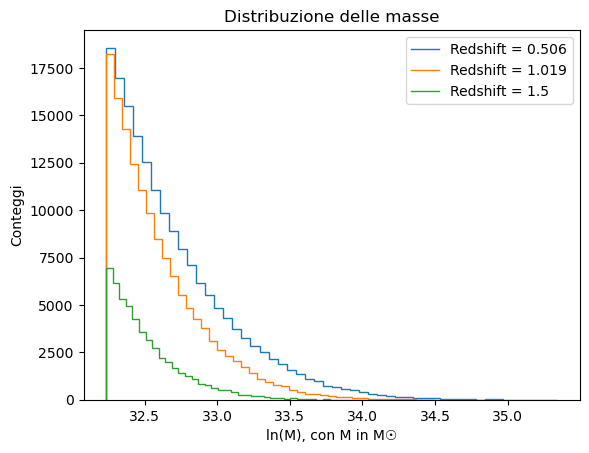

In [25]:
#Istogrammi con la distribuzione delle masse
for i, (z, elem) in enumerate(logdati.groupby('z')):
    counts, edges = np.histogram(elem['Log_Mass'], bins=50)
    plt.stairs(counts, edges, label='Redshift = {}' .format(z))

plt.xlabel("ln(M), con M in M☉")
plt.ylabel("Conteggi")
plt.title('Distribuzione delle masse')
plt.legend()
plt.show()

## Parte 2 - Analisi della Halo Mass Function 

Si usa Colossus per calcolare il numero di aloni attesi per bin di logaritmico di massa (mfunc): si sovrappongono gli istogrammi dei dati del punto precedente alle curve ottenute dalle predizioni teoriche.

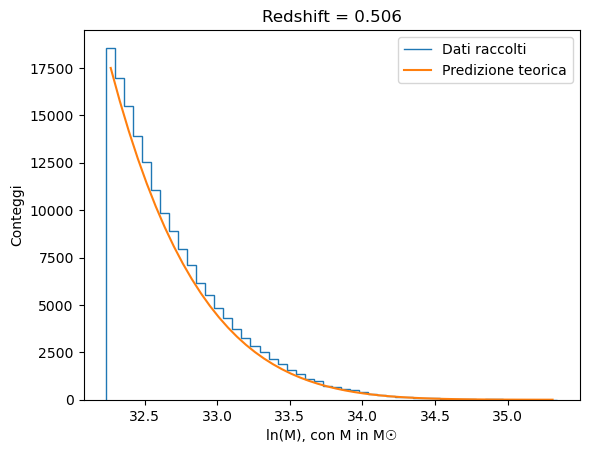

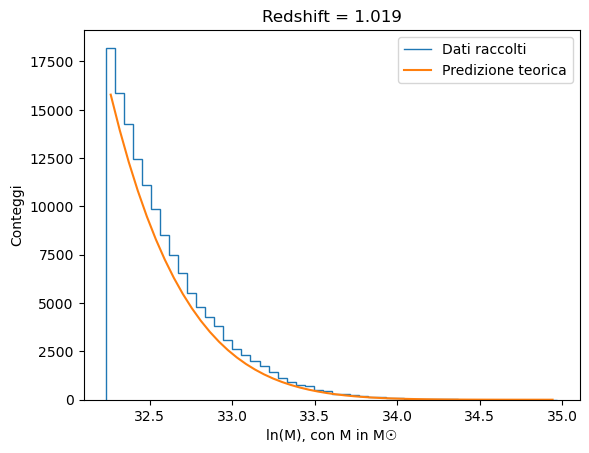

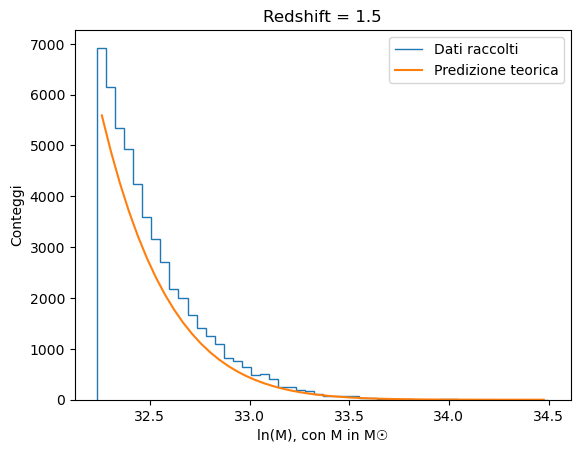

In [27]:
#Parametri cosmologici
params = {'flat': True, 'H0': 67.77, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.96}
cosmology.addCosmology('myCosmo', params)
cosmo = cosmology.setCosmology('myCosmo')


#Istogrammi e curve teoriche: si valuta mfunc nei valori centrali dei bin di ln(M)
for i, (z, elem) in enumerate(logdati.groupby('z')): 
    counts, edges = np.histogram(elem['Log_Mass'], bins=50)
    xx = 0.5*(edges[:(len(edges)-1)]+edges[1:])
    dx = xx[1]-xx[0]
    mfunc = mass_function.massFunction(np.exp(xx), z, mdef='vir', model='despali16', q_out='dndlnM') 
    attesi = mfunc*dx*volumi[i]        #Si moltiplica per il volume di universo associato (volumi[i]) e larghezza 
                                       #del bin (dx) per ottenere il numero atteso per ogni bin
                            
    plt.stairs(counts, edges, label='Dati raccolti')
    plt.plot(xx, attesi, label='Predizione teorica') 
    plt.title(label='Redshift = {}' .format(z))
    plt.xlabel("ln(M), con M in M☉")
    plt.ylabel("Conteggi")
    plt.legend()
    plt.show()

Graficamente si nota che l'andamento della curva teorica approssima la distribuzione dei dati, tuttavia è chiaro che l'accordo non è ottimale.

# Parte 3 - Inferenza Bayesiana sui parametri cosmologici

Si usa l'algoritmo EMCEE per eseguire l'inferenza bayesiana sui parametri cosmologici $sigma8$ e $Om0$: si cercano le posterior e le migliori stime dei parametri per ogni valore di redshift. 

Come prior sui parametri si usa una distribuzione uniforme su $[0.1,1.1] \times [0.1,1.1]$; si assume che il numero di valori che cade in ogni bin di un istogramma ($n_i$ per l'$i$-esimo bin) segua una distribuzione di Poisson con $\mu_i$ determinato dalla predizione teorica (mfunc), per cui la funzione di likelihood sarà $$\mathcal{L}(n_1, ..., n_N|\mu_1, ..., \mu_N) = \prod_{i=1}^{N}e^{-\mu_i}\frac{\mu_i^{n_i}}{n_i!}.$$


Se dalla teoria fosse previsto che le migliori stime dei parametri siano le stesse per ogni valore di redshift, allora avrebbe senso fare anche un'analisi congiunta dei tre campioni, così da avere un set di dati più vasto.

### Redshift = 0.506

C:\Users\Giacomo Tonet\AppData\Local\Temp\ipykernel_1384\2846240575.py:31: RuntimeWarning: divide by zero encountered in log
  prob = np.log(st.poisson.pmf(counts,attesi))  #Si calcolano i logaritmi delle probabilità per ogni bin
  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\Giacomo Tonet\AppData\Roaming\Python\Python311\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [41:37<00:00,  2.50s/it]


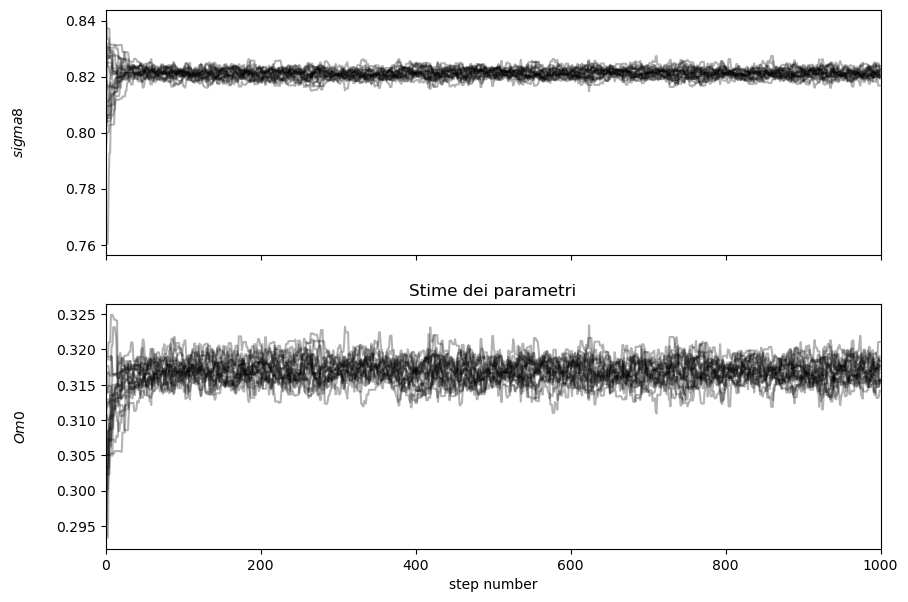

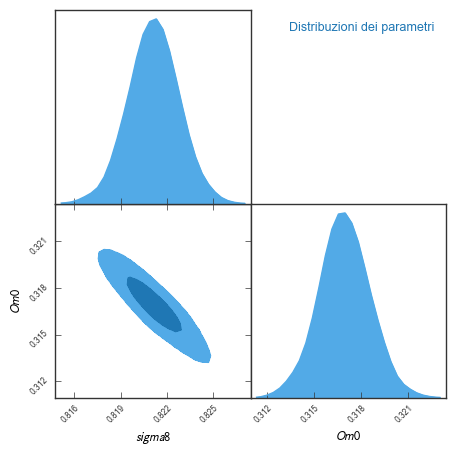

In [19]:
#Set di dati utilizzato
for i, (red, elem) in enumerate(logdati.groupby('z')):
    if i == 0:
        counts, edges = np.histogram(elem['Log_Mass'], bins=50)
        xx = 0.5*(edges[:(len(edges)-1)]+edges[1:])
        dx = xx[1]-xx[0]
        z = red
        vol = volumi[i]


#Definizione di prior, likelihood e posterior
def log_prior(theta):
    sigma8, Om0 = theta
    if (sigma8 < 0.1 or sigma8 > 1.1):
        z = -np.inf
    elif (Om0 < 0.1 or Om0 > 1.1):
        z = -np.inf
    else:
        z = 0
    return z


def log_likelihood(theta, counts, xx, dx, z):  
    sigma8, Om0 = theta
    params = {'flat': True, 'H0': 67.77, 'Om0': Om0, 'Ob0': 0.049, 'sigma8': sigma8, 'ns': 0.95}
    cosmology.addCosmology('myCosmo', params)
    cosmo = cosmology.setCosmology('myCosmo')
    
    mfunc = mass_function.massFunction(np.exp(xx), z, mdef='vir', model='despali16', q_out='dndlnM') 
    attesi = mfunc*vol*dx
    prob = np.log(st.poisson.pmf(counts,attesi))  #Si calcolano i logaritmi delle probabilità per ogni bin
    return np.nansum(prob)


def log_posterior(theta, counts, xx, dx, z):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, counts, xx, dx, z)




#Algoritmo EMCEE
pos = np.array([0.81,0.31]) * (1+ 3e-2 * np.random.randn(20, 2))                         #Valori iniziali
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(counts, xx, dx, z))
sampler.run_mcmc(pos, 1000, progress=True);


#Correzione burn-in
flat_samples = sampler.get_chain(discard=100, flat=True)


#Grafico con i dati generati
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$sigma8$", "$Om0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.title('Stime dei parametri')
plt.show()


#Grafico delle distribuzioni
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=["$sigma8$", "$Om0$"],
                    chainLabels=['Distribuzioni dei parametri'],
                    figureSize='MNRAS_page')
plt.show()


#Salvataggio dei dati
dati1 = flat_samples

Si studiano alcune proprietà statistiche dei parametri generati; si confronta l'istogramma delle masse con la predizione teorica ottenuta dalle migliori stime dei parametri $sigma8$ e $Om0$.

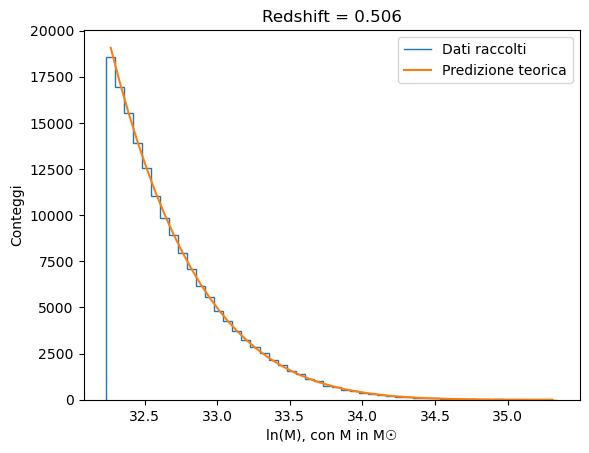

  Parametri     Media   Mediana  Deviazione standard  Erorre relativo
0    Sigma8  0.821127  0.821145             0.001622         0.001975
1       Om0  0.316930  0.316895             0.001614         0.005094


In [60]:
stat1 =  pd.DataFrame(data={'Parametri': ['Sigma8', 'Om0']})
stat1['Media'] = (np.mean(dati1, axis = 0))   
stat1['Mediana'] = (np.median(dati1, axis = 0))
stat1['Deviazione standard'] = (np.std(dati1, axis = 0))
stat1['Erorre relativo'] = stat1['Deviazione standard']/stat1['Media']


#Confronto istogramma - curva teorica con nuovi parametri
params = {'flat': True, 'H0': 67.77, 'Om0': stat1['Media'][1], 'Ob0': 0.049, 'sigma8': stat1['Media'][0], 'ns': 0.96}
cosmology.addCosmology('myCosmo', params)
cosmo = cosmology.setCosmology('myCosmo')

for i, (red, elem) in enumerate(logdati.groupby('z')):
    if i == 0:   
        counts, edges = np.histogram(elem['Log_Mass'], bins=50)
        xx = 0.5*(edges[:(len(edges)-1)]+edges[1:])
        dx = xx[1]-xx[0]
        mfunc = mass_function.massFunction(np.exp(xx), red, mdef='vir', model='despali16', q_out='dndlnM') 
        attesi = mfunc*dx*volumi[i]        
    
        pearson1[i] = np.sum((counts - attesi)**2/attesi)   #Si effettua il test di Pearson per valutare l'accordo tra 
                                                            #istogramma e curva teorica.

        plt.stairs(counts, edges, label='Dati raccolti')
        plt.plot(xx, attesi, label='Predizione teorica') 
        plt.title(label='Redshift = {}' .format(red))
        plt.xlabel("ln(M), con M in M☉")
        plt.ylabel("Conteggi")
        plt.legend()
        plt.show()

        
print(stat1)

### Redshift = 1.019

100%|██████████| 1000/1000 [40:47<00:00,  2.45s/it]


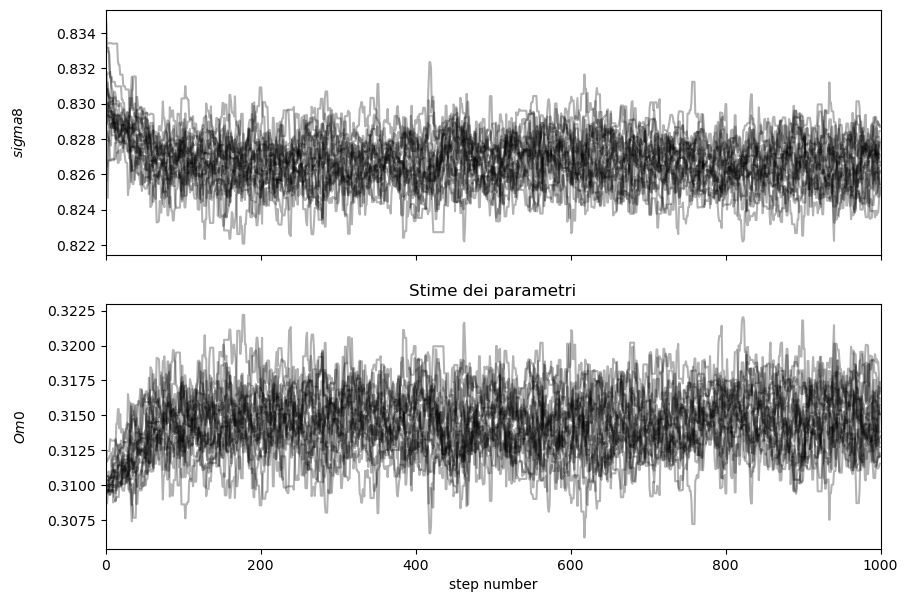

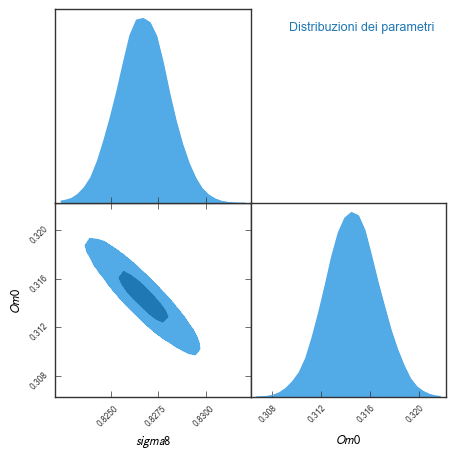

In [22]:
#Set di dati utilizzato
for i, (red, elem) in enumerate(logdati.groupby('z')):
    if i == 1:
        counts, edges = np.histogram(elem['Log_Mass'], bins=50)
        xx = 0.5*(edges[:(len(edges)-1)]+edges[1:])
        dx = xx[1]-xx[0]
        z = red
        vol = volumi[i]


#Definizione di prior, likelihood e posterior
def log_prior(theta):
    sigma8, Om0 = theta
    if (sigma8 < 0.1 or sigma8 > 1.1):
        z = -np.inf
    elif (Om0 < 0.1 or Om0 > 1.1):
        z = -np.inf
    else:
        z = 0
    return z


def log_likelihood(theta, counts, xx, dx, z):  
    sigma8, Om0 = theta
    params = {'flat': True, 'H0': 67.77, 'Om0': Om0, 'Ob0': 0.049, 'sigma8': sigma8, 'ns': 0.95}
    cosmology.addCosmology('myCosmo', params)
    cosmo = cosmology.setCosmology('myCosmo')
    
    mfunc = mass_function.massFunction(np.exp(xx), z, mdef='vir', model='despali16', q_out='dndlnM') 
    attesi = mfunc*vol*dx
    prob = np.log(st.poisson.pmf(counts,attesi))  #Si calcolano i logaritmi delle probabilità per ogni bin
    return np.nansum(prob)


def log_posterior(theta, counts, xx, dx, z):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, counts, xx, dx, z)




#Algoritmo EMCEE
pos = np.array([0.83,0.31]) * (1+ 3e-3 * np.random.randn(20, 2))                         #Valori iniziali
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(counts, xx, dx, z))
sampler.run_mcmc(pos, 1000, progress=True);


#Correzione burn-in
flat_samples = sampler.get_chain(discard=100, flat=True)


#Grafico con i dati generati
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$sigma8$", "$Om0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.title('Stime dei parametri')
plt.show()


#Grafico delle distribuzioni
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=["$sigma8$", "$Om0$"],
                    chainLabels=['Distribuzioni dei parametri'],
                    figureSize='MNRAS_page')
plt.show()


#Salvataggio dei dati
dati2 = flat_samples

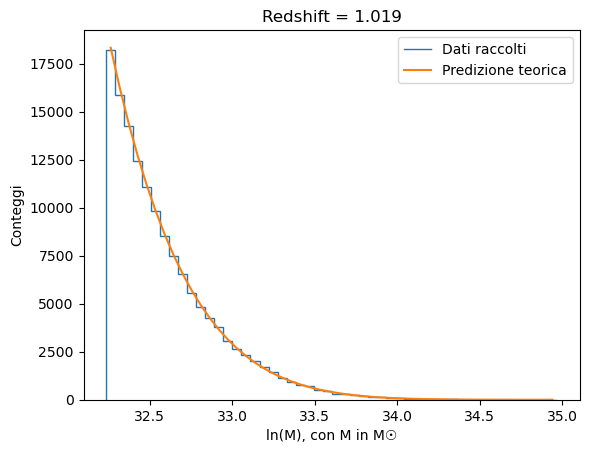

  Parametri     Media   Mediana  Deviazione standard  Erorre relativo
0    Sigma8  0.826681  0.826675             0.001334         0.001614
1       Om0  0.314558  0.314543             0.002122         0.006745


In [62]:
stat2 =  pd.DataFrame(data={'Parametri': ['Sigma8', 'Om0']})
stat2['Media'] = (np.mean(dati2, axis = 0))   
stat2['Mediana'] = (np.median(dati2, axis = 0))
stat2['Deviazione standard'] = (np.std(dati2, axis = 0))
stat2['Erorre relativo'] = stat2['Deviazione standard']/stat2['Media']


#Confronto istogramma - curva teorica con nuovi parametri
params = {'flat': True, 'H0': 67.77, 'Om0': stat2['Media'][1], 'Ob0': 0.049, 'sigma8': stat2['Media'][0], 'ns': 0.96}
cosmology.addCosmology('myCosmo', params)
cosmo = cosmology.setCosmology('myCosmo')

for i, (red, elem) in enumerate(logdati.groupby('z')):
    if i == 1:   
        counts, edges = np.histogram(elem['Log_Mass'], bins=50)
        xx = 0.5*(edges[:(len(edges)-1)]+edges[1:])
        dx = xx[1]-xx[0]
        mfunc = mass_function.massFunction(np.exp(xx), red, mdef='vir', model='despali16', q_out='dndlnM') 
        attesi = mfunc*dx*volumi[i]        
    
        pearson1[i] = np.sum((counts - attesi)**2/attesi)

        plt.stairs(counts, edges, label='Dati raccolti')
        plt.plot(xx, attesi, label='Predizione teorica') 
        plt.title(label='Redshift = {}' .format(red))
        plt.xlabel("ln(M), con M in M☉")
        plt.ylabel("Conteggi")
        plt.legend()
        plt.show()

        
print(stat2)

### Redshift = 1.5

100%|██████████| 1000/1000 [43:50<00:00,  2.63s/it]


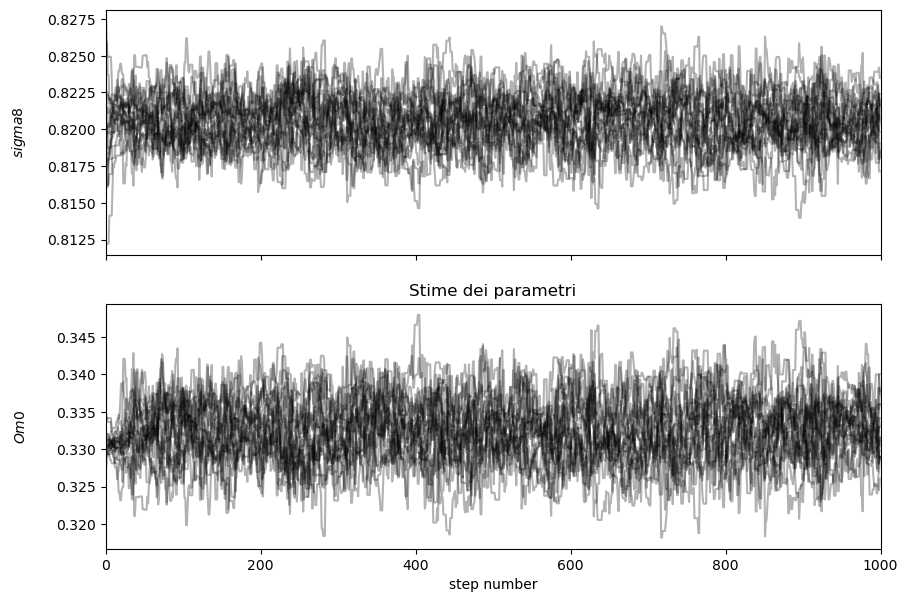

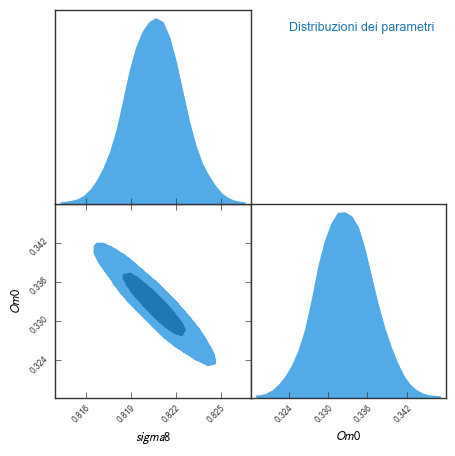

In [6]:
#Set di dati utilizzato
for i, (red, elem) in enumerate(logdati.groupby('z')):
    if i == 2:
        counts, edges = np.histogram(elem['Log_Mass'], bins=50)
        xx = 0.5*(edges[:(len(edges)-1)]+edges[1:])
        dx = xx[1]-xx[0]
        z = red
        vol = volumi[i]


#Definizione di prior, likelihood e posterior
def log_prior(theta):
    sigma8, Om0 = theta
    if (sigma8 < 0.1 or sigma8 > 1.1):
        z = -np.inf
    elif (Om0 < 0.1 or Om0 > 1.1):
        z = -np.inf
    else:
        z = 0
    return z


def log_likelihood(theta, counts, xx, dx, z):  
    sigma8, Om0 = theta
    params = {'flat': True, 'H0': 67.77, 'Om0': Om0, 'Ob0': 0.049, 'sigma8': sigma8, 'ns': 0.95}
    cosmology.addCosmology('myCosmo', params)
    cosmo = cosmology.setCosmology('myCosmo')
    
    mfunc = mass_function.massFunction(np.exp(xx), z, mdef='vir', model='despali16', q_out='dndlnM') 
    attesi = mfunc*vol*dx
    prob = np.log(st.poisson.pmf(counts,attesi))  #Si calcolano i logaritmi delle probabilità per ogni bin
    return np.nansum(prob)


def log_posterior(theta, counts, xx, dx, z):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, counts, xx, dx, z)




#Algoritmo EMCEE
pos = np.array([0.82,0.33]) * (1+ 3e-3 * np.random.randn(20, 2))                         #Valori iniziali
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(counts, xx, dx, z))
sampler.run_mcmc(pos, 1000, progress=True);


#Correzione burn-in
flat_samples = sampler.get_chain(discard=100, flat=True)


#Grafico con i dati generati
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$sigma8$", "$Om0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.title('Stime dei parametri')
plt.show()


#Grafico delle distribuzioni
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=["$sigma8$", "$Om0$"],
                    chainLabels=['Distribuzioni dei parametri'],
                    figureSize='MNRAS_page')
plt.show()


#Salvataggio dei dati
dati3 = flat_samples

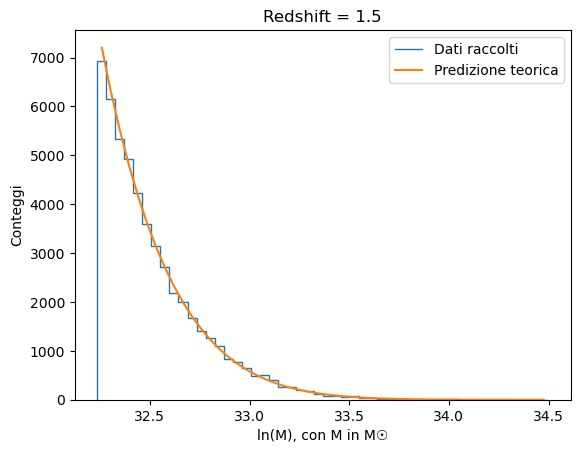

  Parametri     Media   Mediana  Deviazione standard  Erorre relativo
0    Sigma8  0.820571  0.820574             0.001769         0.002156
1       Om0  0.332559  0.332524             0.004122         0.012395


In [63]:
stat3 =  pd.DataFrame(data={'Parametri': ['Sigma8', 'Om0']})
stat3['Media'] = (np.mean(dati3, axis = 0))   
stat3['Mediana'] = (np.median(dati3, axis = 0))
stat3['Deviazione standard'] = (np.std(dati3, axis = 0))
stat3['Erorre relativo'] = stat3['Deviazione standard']/stat3['Media']


#Confronto istogramma - curva teorica con nuovi parametri
params = {'flat': True, 'H0': 67.77, 'Om0': stat3['Media'][1], 'Ob0': 0.049, 'sigma8': stat3['Media'][0], 'ns': 0.96}
cosmology.addCosmology('myCosmo', params)
cosmo = cosmology.setCosmology('myCosmo')

for i, (red, elem) in enumerate(logdati.groupby('z')):
    if i == 2:   
        counts, edges = np.histogram(elem['Log_Mass'], bins=50)
        xx = 0.5*(edges[:(len(edges)-1)]+edges[1:])
        dx = xx[1]-xx[0]
        mfunc = mass_function.massFunction(np.exp(xx), red, mdef='vir', model='despali16', q_out='dndlnM') 
        attesi = mfunc*dx*volumi[i]        
    
        pearson1[i] = np.sum((counts - attesi)**2/attesi)

        plt.stairs(counts, edges, label='Dati raccolti')
        plt.plot(xx, attesi, label='Predizione teorica') 
        plt.title(label='Redshift = {}' .format(red))
        plt.xlabel("ln(M), con M in M☉")
        plt.ylabel("Conteggi")
        plt.legend()
        plt.show()

        
print(stat3)

## Analisi sulla Curvatura dell'Universo

Si usa l'algoritmo EMCEE per eseguire l'inferenza bayesiana sui parametri cosmologici $sigma8$, $Om0$ e $Ode0$: come prior su $sigma8$ e $Om0$ si usa la distribuzione uniforme su $[0.1,1.1] \times [0.1,1.1]$, per $Ode0$ si usa la gaussiana $N$($\mu$ = 0.7, $\sigma$ = 0.05).

### Redshift = 0.506

100%|██████████| 1000/1000 [42:32<00:00,  2.55s/it]


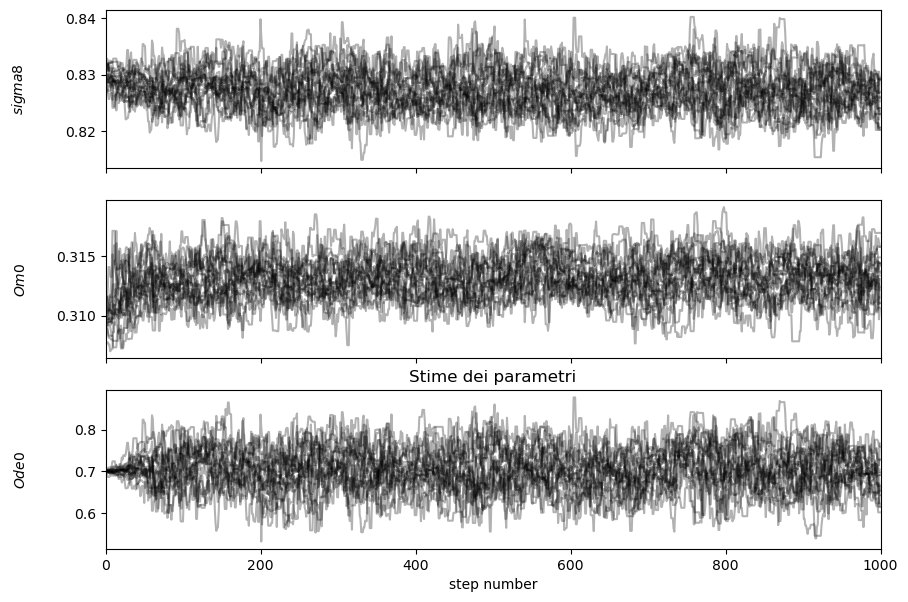

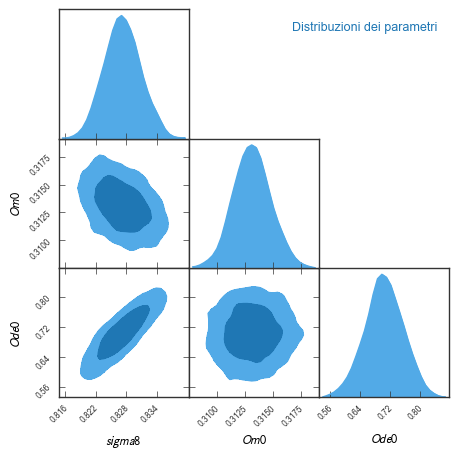

In [23]:
#Set di dati utilizzato
for i, (red, elem) in enumerate(logdati.groupby('z')):
    if i == 0:
        counts, edges = np.histogram(elem['Log_Mass'], bins=50)
        xx = 0.5*(edges[:(len(edges)-1)]+edges[1:])
        dx = xx[1]-xx[0]
        z = red
        vol = volumi[i]


#Definizione di prior, likelihood e posterior
def log_prior(theta):
    sigma8, Om0, Ode0= theta
    if (sigma8 < 0.1 or sigma8 > 1.1):
        z = -np.inf
    elif (Om0 < 0.1 or Om0 > 1.1):
        z = -np.inf
    elif (Ode0 < 0.0):
        z = -np.inf
    else:
        z = np.log( st.norm.pdf(Ode0, loc=0.7, scale=0.05))
    return z


def log_likelihood(theta, counts, xx, dx, z):  
    sigma8, Om0, Ode0 = theta
    params = {'flat': False, 'H0': 67.77, 'Ode0': Ode0, 'Om0': Om0, 'Ob0': 0.048254, 'sigma8': sigma8, 'ns': 0.96}
    cosmology.addCosmology('myCosmo', params)
    cosmo = cosmology.setCosmology('myCosmo')
    
    mfunc = mass_function.massFunction(np.exp(xx), z, mdef='vir', model='despali16', q_out='dndlnM')
    attesi = mfunc*vol*dx
    prob = np.log(st.poisson.pmf(counts,attesi)) 
    return np.nansum(prob)


def log_posterior(theta, counts, xx, dx, z):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, counts, xx, dx, z)




#Algoritmo EMCEE
pos = np.array([0.83,0.31,0.7]) * (1+ 3e-3 * np.random.randn(20, 3))                         #Valori iniziali
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(counts, xx, dx, z))
sampler.run_mcmc(pos, 1000, progress=True);
   

#Correzione burn-in
flat_samples = sampler.get_chain(discard=100, flat=True)


#Grafico punti
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$sigma8$", "$Om0$", "$Ode0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.title('Stime dei parametri')
plt.show()


#Grafico Distribuzioni
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=["$sigma8$", "$Om0$", "$Ode0$"],
                    chainLabels=['Distribuzioni dei parametri'],
                    figureSize='MNRAS_page')
plt.show()


#Salvataggio dei dati
dati1bis = flat_samples

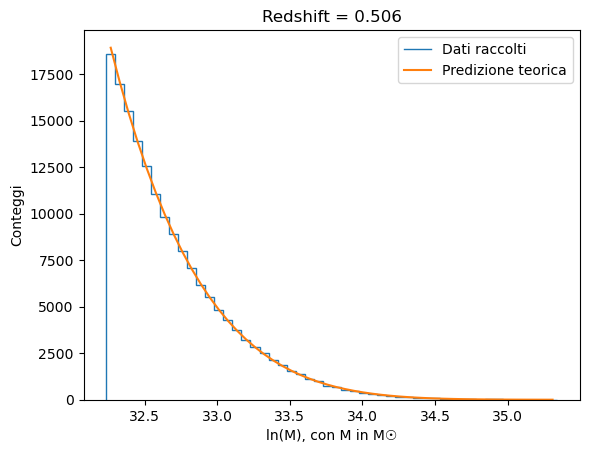

  Parametri     Media   Mediana  Deviazione standard  Erorre relativo
0    Sigma8  0.827226  0.827177             0.003553         0.004295
1       Om0  0.313140  0.313113             0.001649         0.005267
2      Ode0  0.704113  0.703905             0.050284         0.071415


In [71]:
stat1bis =  pd.DataFrame(data={'Parametri': ['Sigma8', 'Om0', 'Ode0']})
stat1bis['Media'] = (np.mean(dati1bis, axis = 0))   
stat1bis['Mediana'] = (np.median(dati1bis, axis = 0))
stat1bis['Deviazione standard'] = (np.std(dati1bis, axis = 0))
stat1bis['Erorre relativo'] = stat1bis['Deviazione standard']/stat1bis['Media']


#Confronto istogramma - curva teorica con nuovi parametri
params = {'flat': False, 'H0': 67.77, 'Ode0': stat1bis['Media'][2], 'Om0': stat1bis['Media'][1],
          'Ob0': 0.048254, 'sigma8': stat1bis['Media'][0], 'ns': 0.96}
cosmology.addCosmology('myCosmo', params)
cosmo = cosmology.setCosmology('myCosmo')
 
for i, (red, elem) in enumerate(logdati.groupby('z')):
    if i == 0:   
        counts, edges = np.histogram(elem['Log_Mass'], bins=50)
        xx = 0.5*(edges[:(len(edges)-1)]+edges[1:])
        dx = xx[1]-xx[0]
        mfunc = mass_function.massFunction(np.exp(xx), red, mdef='vir', model='despali16', q_out='dndlnM') 
        attesi = mfunc*dx*volumi[i]        
    
        pearson2[i] = np.sum((counts - attesi)**2/attesi)

        plt.stairs(counts, edges, label='Dati raccolti')
        plt.plot(xx, attesi, label='Predizione teorica') 
        plt.title(label='Redshift = {}' .format(red))
        plt.xlabel("ln(M), con M in M☉")
        plt.ylabel("Conteggi")
        plt.legend()
        plt.show()  

        
print(stat1bis)

### Redshift = 1.019

100%|██████████| 1000/1000 [42:27<00:00,  2.55s/it]


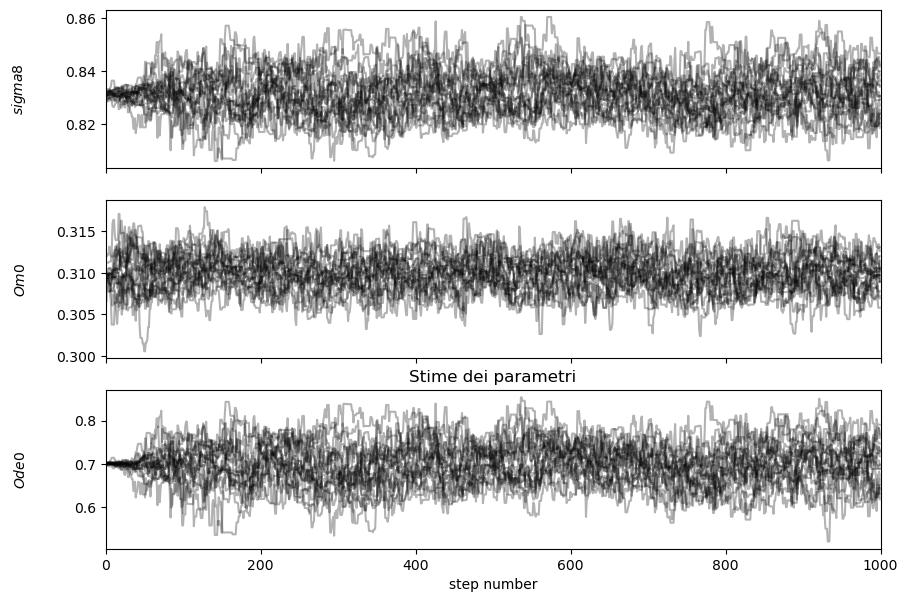

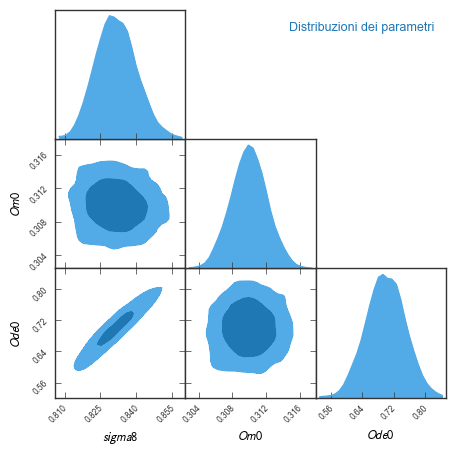

In [37]:
#Set di dati utilizzato
for i, (red, elem) in enumerate(logdati.groupby('z')):
    if i == 1:
        counts, edges = np.histogram(elem['Log_Mass'], bins=50)
        xx = 0.5*(edges[:(len(edges)-1)]+edges[1:])
        dx = xx[1]-xx[0]
        z = red
        vol = volumi[i]


#Definizione di prior, likelihood e posterior
def log_prior(theta):
    sigma8, Om0, Ode0= theta
    if (sigma8 < 0.1 or sigma8 > 1.1):
        z = -np.inf
    elif (Om0 < 0.1 or Om0 > 1.1):
        z = -np.inf
    elif (Ode0 < 0.0):
        z = -np.inf
    else:
        z = np.log( st.norm.pdf(Ode0, loc=0.7, scale=0.05))
    return z


def log_likelihood(theta, counts, xx, dx, z):  
    sigma8, Om0, Ode0 = theta
    params = {'flat': False, 'H0': 67.77, 'Ode0': Ode0, 'Om0': Om0, 'Ob0': 0.048254, 'sigma8': sigma8, 'ns': 0.96}
    cosmology.addCosmology('myCosmo', params)
    cosmo = cosmology.setCosmology('myCosmo')
    
    mfunc = mass_function.massFunction(np.exp(xx), z, mdef='vir', model='despali16', q_out='dndlnM')
    attesi = mfunc*vol*dx
    prob = np.log(st.poisson.pmf(counts,attesi)) 
    return np.nansum(prob)


def log_posterior(theta, counts, xx, dx, z):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, counts, xx, dx, z)




#Algoritmo EMCEE
pos = np.array([0.83,0.31,0.7])* (1+ 3e-3 * np.random.randn(20, 3))                         #Valori iniziali
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(counts, xx, dx, z))
sampler.run_mcmc(pos, 1000, progress=True);
   

#Correzione burn-in
flat_samples = sampler.get_chain(discard=100, flat=True)


#Grafico punti
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$sigma8$", "$Om0$", "$Ode0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.title('Stime dei parametri')
plt.show()


#Grafico Distribuzioni
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=["$sigma8$", "$Om0$", "$Ode0$"],
                    chainLabels=['Distribuzioni dei parametri'],
                    figureSize='MNRAS_page')
plt.show()


#Salvataggio dei dati
dati2bis = flat_samples

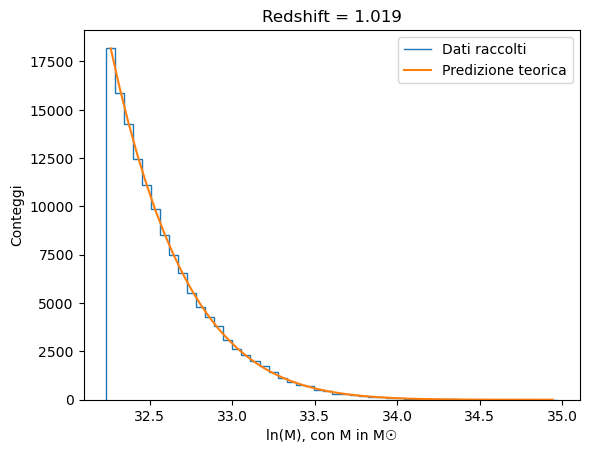

  Parametri     Media   Mediana  Deviazione standard  Erorre relativo
0    Sigma8  0.831561  0.831276             0.008371         0.010066
1       Om0  0.309961  0.309968             0.002081         0.006713
2      Ode0  0.699429  0.698529             0.048986         0.070037


In [64]:
stat2bis =  pd.DataFrame(data={'Parametri': ['Sigma8', 'Om0', 'Ode0']})
stat2bis['Media'] = (np.mean(dati2bis, axis = 0))   
stat2bis['Mediana'] = (np.median(dati2bis, axis = 0))
stat2bis['Deviazione standard'] = (np.std(dati2bis, axis = 0))
stat2bis['Erorre relativo'] = stat2bis['Deviazione standard']/stat2bis['Media']


#Confronto istogramma - curva teorica con nuovi parametri
params = {'flat': False, 'H0': 67.77, 'Ode0': stat2bis['Media'][2], 'Om0': stat2bis['Media'][1], 
          'Ob0': 0.048254, 'sigma8': stat2bis['Media'][0], 'ns': 0.96}
cosmology.addCosmology('myCosmo', params)
cosmo = cosmology.setCosmology('myCosmo')
 
for i, (red, elem) in enumerate(logdati.groupby('z')):
    if i == 1:   
        counts, edges = np.histogram(elem['Log_Mass'], bins=50)
        xx = 0.5*(edges[:(len(edges)-1)]+edges[1:])
        dx = xx[1]-xx[0]
        mfunc = mass_function.massFunction(np.exp(xx), red, mdef='vir', model='despali16', q_out='dndlnM') 
        attesi = mfunc*dx*volumi[i]        
    
        pearson2[i] = np.sum((counts - attesi)**2/attesi)

        plt.stairs(counts, edges, label='Dati raccolti')
        plt.plot(xx, attesi, label='Predizione teorica') 
        plt.title(label='Redshift = {}' .format(red))
        plt.xlabel("ln(M), con M in M☉")
        plt.ylabel("Conteggi")
        plt.legend()
        plt.show()  

        
print(stat2bis)

### Redshift = 1.5

100%|██████████| 1000/1000 [41:51<00:00,  2.51s/it]


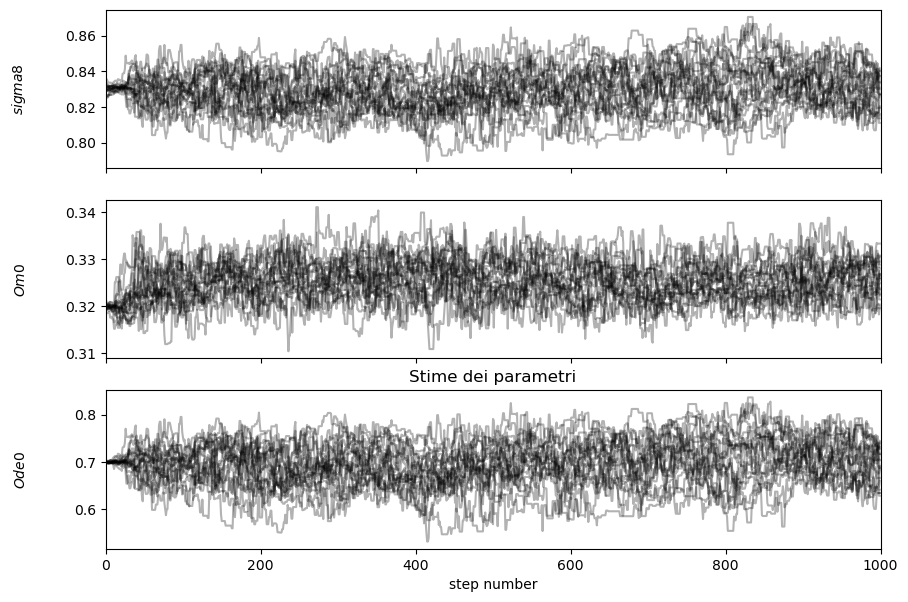

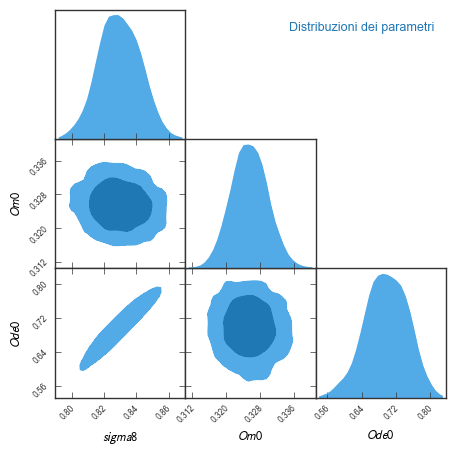

In [39]:
#Set di dati utilizzato
for i, (red, elem) in enumerate(logdati.groupby('z')):
    if i == 2:
        counts, edges = np.histogram(elem['Log_Mass'], bins=50)
        xx = 0.5*(edges[:(len(edges)-1)]+edges[1:])
        dx = xx[1]-xx[0]
        z = red
        vol = volumi[i]


#Definizione di prior, likelihood e posterior
def log_prior(theta):
    sigma8, Om0, Ode0= theta
    if (sigma8 < 0.1 or sigma8 > 1.1):
        z = -np.inf
    elif (Om0 < 0.1 or Om0 > 1.1):
        z = -np.inf
    elif (Ode0 < 0.0):
        z = -np.inf
    else:
        z = np.log( st.norm.pdf(Ode0, loc=0.7, scale=0.05))
    return z


def log_likelihood(theta, counts, xx, dx, z):  
    sigma8, Om0, Ode0 = theta
    params = {'flat': False, 'H0': 67.77, 'Ode0': Ode0, 'Om0': Om0, 'Ob0': 0.048254, 'sigma8': sigma8, 'ns': 0.96}
    cosmology.addCosmology('myCosmo', params)
    cosmo = cosmology.setCosmology('myCosmo')
    
    mfunc = mass_function.massFunction(np.exp(xx), z, mdef='vir', model='despali16', q_out='dndlnM')
    attesi = mfunc*vol*dx
    prob = np.log(st.poisson.pmf(counts,attesi)) 
    return np.nansum(prob)


def log_posterior(theta, counts, xx, dx, z):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, counts, xx, dx, z)




#Algoritmo EMCEE
pos = np.array([0.83,0.32,0.7])* (1+ 3e-3 * np.random.randn(20, 3))                         #Valori iniziali
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(counts, xx, dx, z))
sampler.run_mcmc(pos, 1000, progress=True);
   

#Correzione burn-in
flat_samples = sampler.get_chain(discard=100, flat=True)


#Grafico punti
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$sigma8$", "$Om0$", "$Ode0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.title('Stime dei parametri')
plt.show()


#Grafico Distribuzioni
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=["$sigma8$", "$Om0$", "$Ode0$"],
                    chainLabels=['Distribuzioni dei parametri'],
                    figureSize='MNRAS_page')
plt.show()


#Salvataggio dei dati
dati3bis = flat_samples

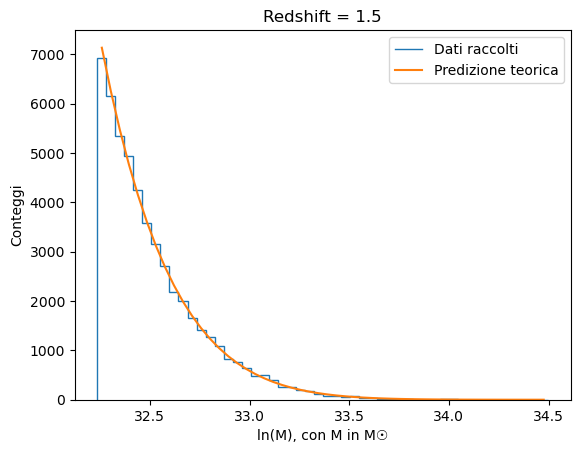

  Parametri     Media   Mediana  Deviazione standard  Erorre relativo
0    Sigma8  0.829511  0.829269             0.012504         0.015074
1       Om0  0.325488  0.325440             0.004102         0.012604
2      Ode0  0.697104  0.697765             0.048090         0.068985


In [65]:
stat3bis =  pd.DataFrame(data={'Parametri': ['Sigma8', 'Om0', 'Ode0']})
stat3bis['Media'] = (np.mean(dati3bis, axis = 0))   
stat3bis['Mediana'] = (np.median(dati3bis, axis = 0))
stat3bis['Deviazione standard'] = (np.std(dati3bis, axis = 0))
stat3bis['Erorre relativo'] = stat3bis['Deviazione standard']/stat3bis['Media']


#Confronto istogramma - curva teorica con nuovi parametri
params = {'flat': False, 'H0': 67.77, 'Ode0': stat3bis['Media'][2], 'Om0': stat3bis['Media'][1], 
          'Ob0': 0.048254, 'sigma8': stat3bis['Media'][0], 'ns': 0.96}
cosmology.addCosmology('myCosmo', params)
cosmo = cosmology.setCosmology('myCosmo')
 
for i, (red, elem) in enumerate(logdati.groupby('z')):
    if i == 2:   
        counts, edges = np.histogram(elem['Log_Mass'], bins=50)
        xx = 0.5*(edges[:(len(edges)-1)]+edges[1:])
        dx = xx[1]-xx[0]
        mfunc = mass_function.massFunction(np.exp(xx), red, mdef='vir', model='despali16', q_out='dndlnM') 
        attesi = mfunc*dx*volumi[i]        
    
        pearson2[i] = np.sum((counts - attesi)**2/attesi)

        plt.stairs(counts, edges, label='Dati raccolti')
        plt.plot(xx, attesi, label='Predizione teorica') 
        plt.title(label='Redshift = {}' .format(red))
        plt.xlabel("ln(M), con M in M☉")
        plt.ylabel("Conteggi")
        plt.legend()
        plt.show()  

        
print(stat3bis)

### Densità di Energia ( $\Omega_k$ )

Dal grafico della distribuzione congiunta di $\Omega_m (Om0)$ e $\Omega_{\Lambda} (Ode0)$ si nota che i parametri si possono considerare come due variabili casuali non correlate. La distribuzione di 
$$ \Omega_k = 1 - \Omega_m - \Omega_{\Lambda} $$ 

sarà dunque determinata dalla convoluzione delle due distribuzioni marginali.

In questo caso si nota che le distribuzioni marginali di $\Omega_m$ e $\Omega_{\Lambda}$ sono approssimabili con delle gaussiane, per cui anche la convoluzione sarà una gaussiana con $\mu = \mu_1 + \mu_2$ e $\sigma^2 = \sigma_1^2 +\sigma_2^2$: la funzione di distribuzione di $\Omega_k$ sarà dunque

$$ N(\mu' = 1- \mu_1 - \mu_2, \;\sigma'^2 = \sigma_1^2 +\sigma_2^2 ). $$

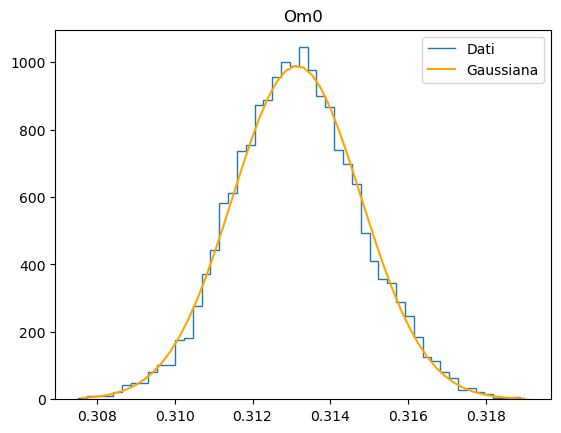

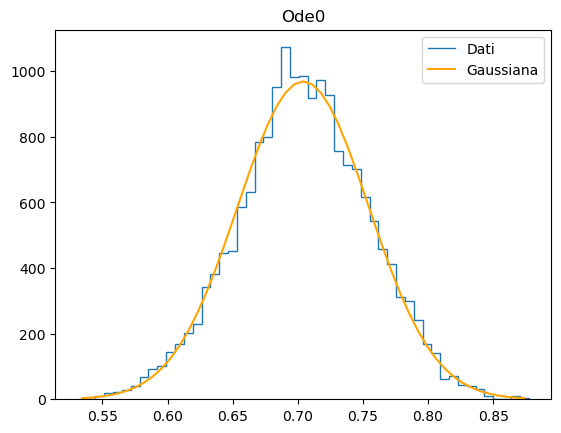

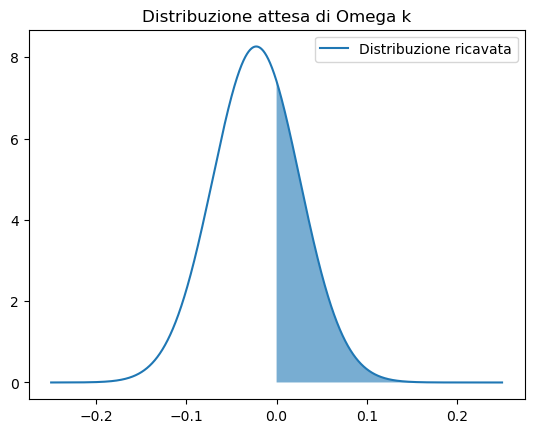

In [68]:
#Plot delle distribuzioni marginali di Om0 e Ode0
Nomi = ['Sigma8', 'Om0', 'Ode0']
for i in range(3): 
    if i == 0:
        continue
    counts, edges = np.histogram(dati1bis[:,i], bins=51)
    xx = 0.5*(edges[:(len(edges)-1)]+edges[1:]) 
    dx = edges[1]-edges[0]
    attesi = st.norm.pdf(xx, loc=np.mean(dati1bis[:,i]), scale=np.std(dati1bis[:,i]))*dx*np.sum(counts)       
    
    plt.stairs(counts, edges, label='Dati')
    plt.plot(xx, attesi, c='orange', label='Gaussiana')
    plt.title(label = '{}' .format(Nomi[i]))
    plt.legend()
    plt.show() 
    

#Plot della distribuzione di Omega k
x = np.linspace(-0.25, 0.25, num=10001)
m1 = np.mean(dati3bis[:,1])
m2 = np.mean(dati3bis[:,2])
s1 = np.std(dati3bis[:,1])
s2 = np.std(dati3bis[:,2])
plt.plot(x, st.norm.pdf(x, loc=1-(m1+m2), scale=np.sqrt(s1**2 + s2**2)),label='Distribuzione ricavata')
plt.fill_between(x[5000:], st.norm.pdf(x[5000:], loc=1-(m1+m2), scale=np.sqrt(s1**2 + s2**2)), alpha = 0.6)
plt.title(label = 'Distribuzione attesa di Omega k')
plt.legend()
plt.show()

## Conclusioni e commenti

In [95]:
#Stampa dei dati ottenuti dalle inferenze
a1 = [stat1, stat2, stat3]
a2 = [stat1bis, stat2bis, stat3bis]

print('Universo piatto')
for i in range(3):
    print()
    print('Redshift = {}' .format(redshift[i]))
    print(a1[i])

print()
print()
print('Universo curvo')
for i in range(3):
    print()
    print('Redshift = {}' .format(redshift[i]))
    print(a2[i])
    
print()
print()
print('Risultati test di Pearson: ipotesi non rigettata per x<65.2, P(x>65.2) = 5% con 50 intervalli')
for i in range(3):
    print()
    print('Redshift = {}' .format(redshift[i]))
    print('Piatto =', pearson1[i], ', Curvo =', pearson2[i]) 

Universo piatto

Redshift = 0.506
  Parametri     Media   Mediana  Deviazione standard  Erorre relativo
0    Sigma8  0.821127  0.821145             0.001622         0.001975
1       Om0  0.316930  0.316895             0.001614         0.005094

Redshift = 1.019
  Parametri     Media   Mediana  Deviazione standard  Erorre relativo
0    Sigma8  0.826681  0.826675             0.001334         0.001614
1       Om0  0.314558  0.314543             0.002122         0.006745

Redshift = 1.5
  Parametri     Media   Mediana  Deviazione standard  Erorre relativo
0    Sigma8  0.820571  0.820574             0.001769         0.002156
1       Om0  0.332559  0.332524             0.004122         0.012395


Universo curvo

Redshift = 0.506
  Parametri     Media   Mediana  Deviazione standard  Erorre relativo
0    Sigma8  0.827226  0.827177             0.003553         0.004295
1       Om0  0.313140  0.313113             0.001649         0.005267
2      Ode0  0.704113  0.703905             0.050284     

Le barre di errore rappresentano una deviazione standard.


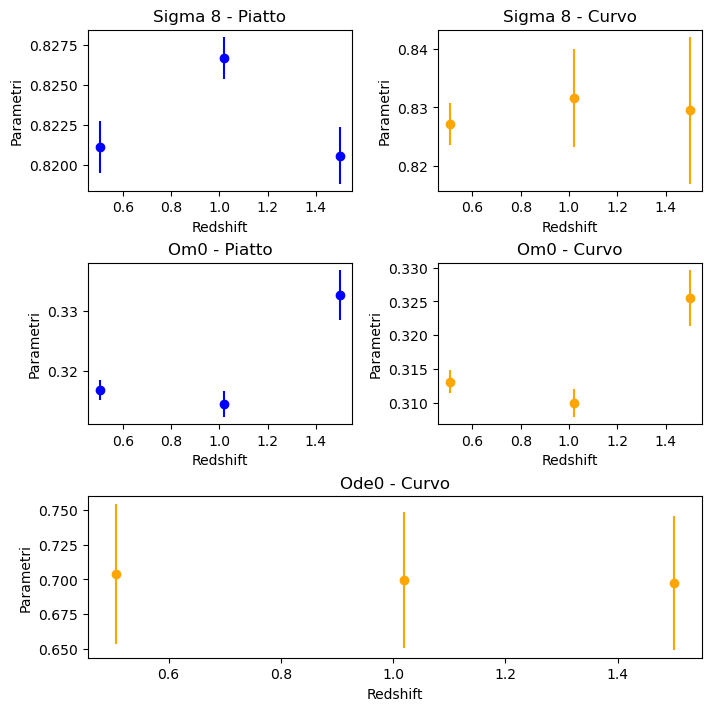

In [101]:
#Rappresentazione grafica delle migliori stime dei parametri
param1 = np.ones((3,2))
errori1 =  np.ones((3,2))
param2 = np.ones((3,3))
errori2 =  np.ones((3,3))

for i in range(3):
    if i<2:
        param1[:,i] = [stat1['Media'][i],stat2['Media'][i],stat3['Media'][i]]
        errori1[:,i] = [stat1['Deviazione standard'][i],stat2['Deviazione standard'][i],stat3['Deviazione standard'][i]]
                      
        param2[:,i] = [stat1bis['Media'][i],stat2bis['Media'][i],stat3bis['Media'][i]]
        errori2[:,i] = [stat1bis['Deviazione standard'][i],stat2bis['Deviazione standard'][i],stat3bis['Deviazione standard'][i]]
        
    if i==2:
        param2[:,i] = [stat1bis['Media'][i],stat2bis['Media'][i],stat3bis['Media'][i]]
        errori2[:,i] = [stat1bis['Deviazione standard'][i],stat2bis['Deviazione standard'][i],stat3bis['Deviazione standard'][i]]
        


#Grafici
fig = plt.figure(figsize=(7, 7), layout='constrained', label='Valori medi dei parametri')
axs = fig.subplot_mosaic([["sp", "sc"],
                          ["omp", "omc"],
                          ["ode", "ode"]])

axs["sp"].set_title("Sigma 8 - Piatto")
axs["sp"].errorbar(redshift, param1[:,0], errori1[:,0], ls=' ',c='blue',  fmt='o')
axs["sp"].set_xlabel("Redshift")
axs["sp"].set_ylabel("Parametri")

axs["sc"].set_title("Sigma 8 - Curvo")
axs["sc"].errorbar(redshift, param2[:,0], errori2[:,0], ls=' ', c='orange', fmt='o')
axs["sc"].set_xlabel("Redshift")
axs["sc"].set_ylabel("Parametri")

axs['omp'].set_title("Om0 - Piatto")
axs['omp'].errorbar(redshift, param1[:,1], errori1[:,1], ls=' ',c='blue',  fmt='o')
axs['omp'].set_xlabel("Redshift")
axs['omp'].set_ylabel("Parametri")

axs['omc'].set_title("Om0 - Curvo")
axs['omc'].errorbar(redshift, param2[:,1], errori2[:,1], ls=' ', c='orange',  fmt='o')
axs['omc'].set_xlabel("Redshift")
axs['omc'].set_ylabel("Parametri")

axs['ode'].set_title("Ode0 - Curvo")
axs['ode'].errorbar(redshift, param2[:,2], errori2[:,2], ls=' ', c='orange',  fmt='o')
axs['ode'].set_xlabel("Redshift")
axs['ode'].set_ylabel("Parametri")


print('Le barre di errore rappresentano una deviazione standard.')
plt.show()

In generale si nota che le migliori stime dei parametri sono compatibili tra loro entro tre deviazioni standard per ogni valore di redshift.

Il test di Pearson effettuato con gli istogrammi dei dati raccolti mostra che c'è un migliore accordo tra dati e previsione teorica per l'universo curvo, ma questo si spiega nel fatto che nel secondo caso si lavora con un parametro in più; in generale però il test porta a rigettare l'ipotesi di accordo per cui si dovrebbe eseguire l'inferenza su un numero più alto di parametri.